In [1]:
import sys
sys.path.append('../../../')

In [2]:
import os
os.chdir('../../../')

In [3]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import QED
from rdkit.Chem.Draw import MolsToGridImage

from app.api.sbdd_sample import sample_against_pockets
from app.api.sbdd_sample import build_pocket_conditional_sampler

/home/tsa87/anaconda3/envs/cgflow/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
POSE_CKPT_PATH = "weights/crossdocked2020_till_end.ckpt"
CGFLOW_CKPT_PATH = "weights/sbdd-stock-zincdock/model_state_16000.pt"
ENV_DIR = "experiments/data/envs/catalog/"
POCKET_PATHS = [
    "src/app/test/topo2_pocket.pdb"
]

In [1]:
trajs = [['', ['block23', '23', '[23*]c1ccc2c(c1)CNC2=O']], ['[23*]c1ccc2c(c1)CNC2=O', ['rxn34_linker_b1', '21-23', '[21*]c1cccc([23*])c1']], ['[23*]c1cccc(-c2ccc3c(c2)CNC3=O)c1', ['rxn34_brick_b1', '21', '[21*]c1ccc2c(c1)CC(C)N2']]]

In [3]:
trajs[0]

['', ['block23', '23', '[23*]c1ccc2c(c1)CNC2=O']]

In [4]:
trajs[1]

['[23*]c1ccc2c(c1)CNC2=O',
 ['rxn34_linker_b1', '21-23', '[21*]c1cccc([23*])c1']]

In [8]:
from rdkit import Chem 
display(Chem.MolFromSmiles(trajs[2][0]))

In [9]:
import torch

pose_state_stock_ckpt_path = "weights/crossdocked2020_till_end_stock_cgflow.ckpt"
if not os.path.exists(pose_state_stock_ckpt_path):
    pose_state = torch.load(POSE_CKPT_PATH, map_location='cuda', weights_only=False)
    cgflow_state = torch.load(CGFLOW_CKPT_PATH,weights_only=False)

    pose_state_stock_cgflow = pose_state.copy()
    pose_state_stock_cgflow['cfg'] = cgflow_state['cfg']
    pose_state_stock_cgflow['models_state_dict'] = cgflow_state['models_state_dict']
    torch.save(pose_state_stock_cgflow, pose_state_stock_ckpt_path)


In [11]:
sampler = build_pocket_conditional_sampler(
    ckpt_path=pose_state_stock_ckpt_path,
    env_dir=ENV_DIR,
    temperature=(48, 64),
    num_samples=100,
    device="cuda",
    seed=1,
)

CGFlowConfig(arch='semla', dataset='plinder', self_condition=True, d_model=384, n_layers=12, d_message=64, d_edge=128, n_coord_sets=64, n_attn_heads=32, d_message_hidden=96, coord_norm='length', pocket_n_layers=4, pocket_d_inv=256, fixed_equi=False, num_inference_steps=100, ode_sampling_strategy='linear', optimal_transport='None', decomposition_strategy='reaction', ordering_strategy='connected', t_per_ar_action=0.33, max_interp_time=1.0, max_action_t=0.66, max_num_cuts=2)


In [14]:
output = sample_against_pockets(
    sampler=sampler,
    pocket_paths=POCKET_PATHS,
    num_samples=100,
    seed=1,
)

In [31]:
output[0][0]

[{'mol': <rdkit.Chem.rdchem.Mol at 0x7f573ee693f0>,
  'smiles': 'COc1cc(-c2ccc(C(N)=O)c(-c3ccc4c(c3)CNC4=O)c2)cc2c1NC(=O)C2',
  'traj': [('', ('block23', '23', '[23*]c1ccc2c(c1)CNC2=O')),
   ('[23*]c1ccc2c(c1)CNC2=O',
    ('rxn34_linker_b1', '21-23', '[21*]c1cc([23*])ccc1C(N)=O')),
   ('[23*]c1ccc(C(N)=O)c(-c2ccc3c(c2)CNC3=O)c1',
    ('rxn34_brick_b1', '21', '[21*]c1cc2c(c(OC)c1)NC(=O)C2'))],
  'info': {'beta': 56.7810173034668}},
 {'mol': <rdkit.Chem.rdchem.Mol at 0x7f573ee69460>,
  'smiles': 'CN1Cc2cc(-c3cc(-c4cccc5c4C(C(=O)O)C5)ccc3C#N)ccc2C1=O',
  'traj': [('', ('block23', '23', '[23*]c1ccc2c(c1)CN(C)C2=O')),
   ('[23*]c1ccc2c(c1)CN(C)C2=O',
    ('rxn34_linker_b1', '21-23', '[21*]c1cc([23*])ccc1C#N')),
   ('[23*]c1ccc(C#N)c(-c2ccc3c(c2)CN(C)C3=O)c1',
    ('rxn34_brick_b1', '21', '[21*]c1cccc2c1C(C(=O)O)C2'))],
  'info': {'beta': 59.443031311035156}},
 {'mol': <rdkit.Chem.rdchem.Mol at 0x7f573ee69000>,
  'smiles': 'CS1(=O)=NCc2ccc(-c3cc(N)cc(-c4ccc5c(c4)CNC5=O)c3)cc21',
  'traj': [(

In [15]:
results = output[0][0]

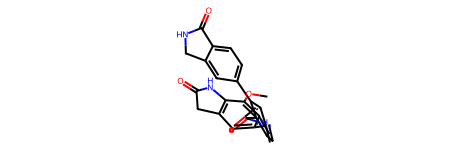

In [16]:
results[0]['mol']

In [17]:
mols = [Chem.MolFromSmiles(Chem.MolToSmiles(mol['mol'])) for mol in results]
# sas = [calculate_sa_score(mol) for mol in mols]
qeds = [QED.qed(mol) for mol in mols]

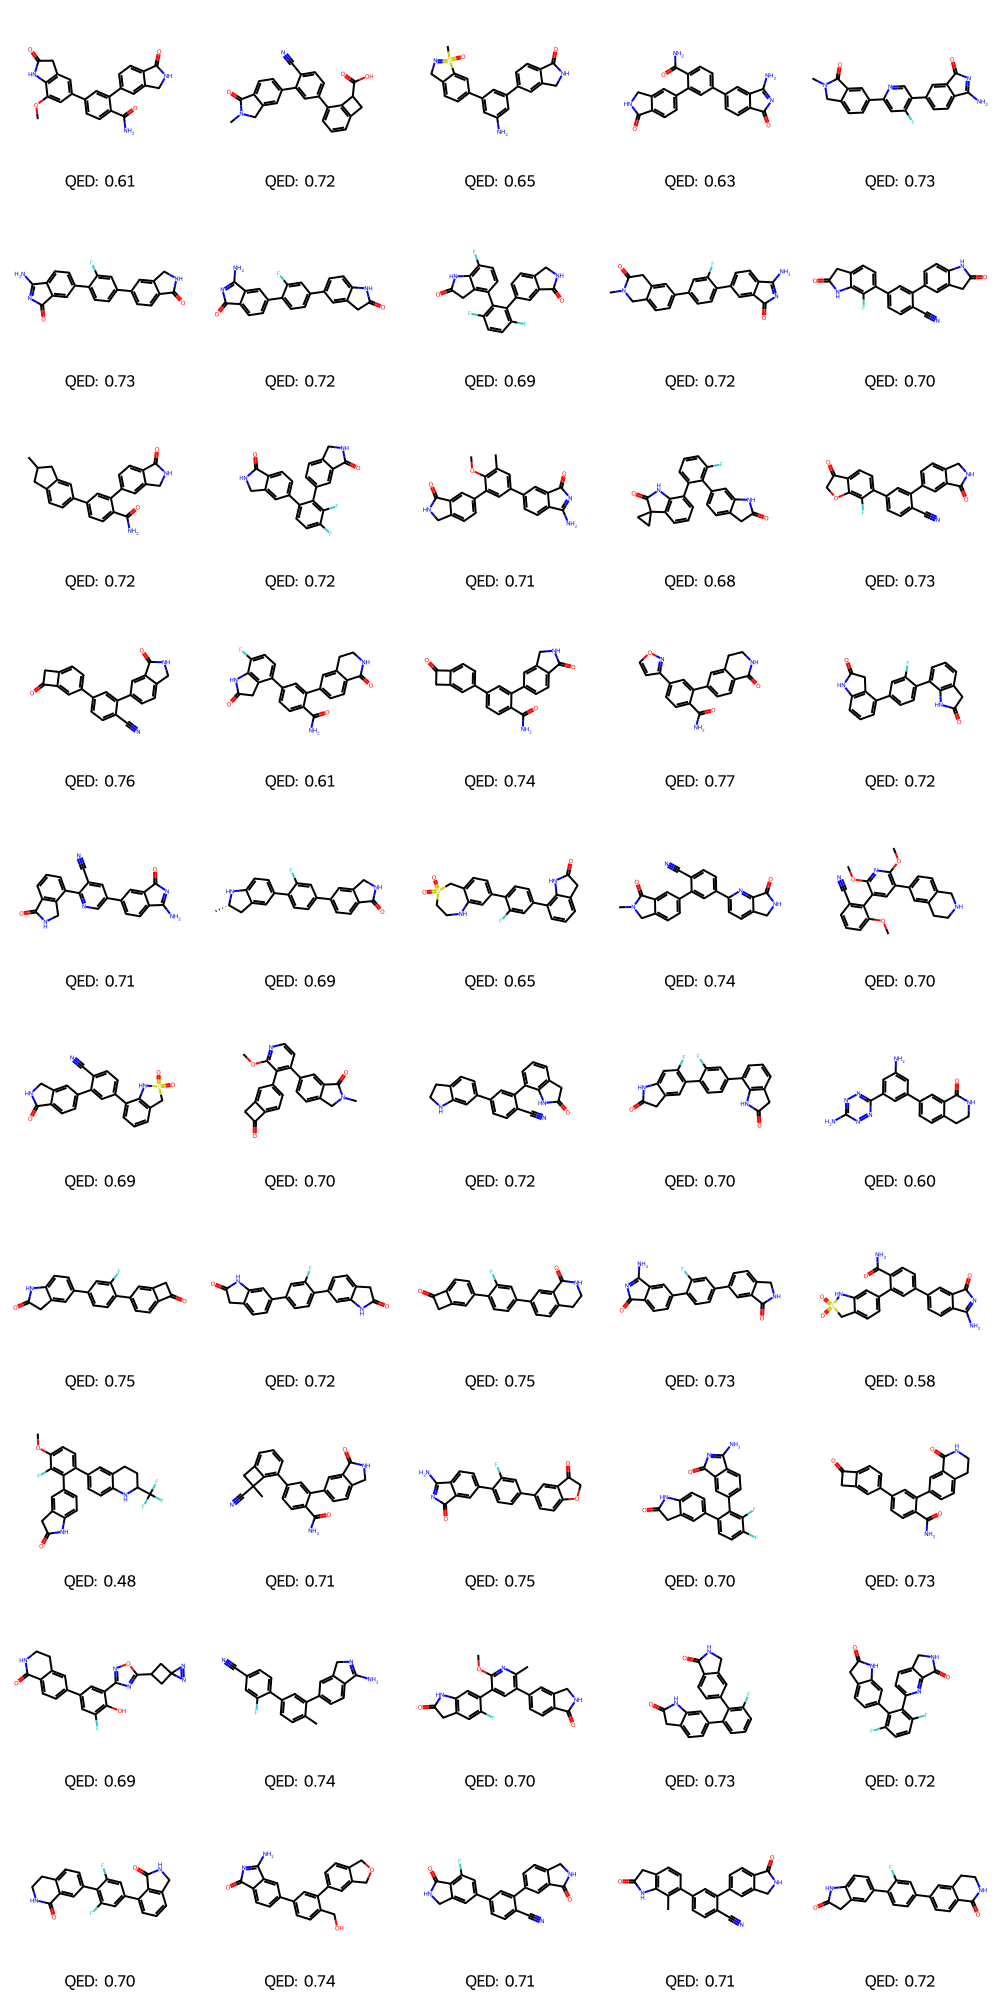

In [26]:
subset_mols = mols[:50]
MolsToGridImage(subset_mols, molsPerRow=5, legends=[f'QED: {qeds[i]:.2f}' for i in range(len(subset_mols))])

In [19]:
results[0]['traj']

[('', ('block23', '23', '[23*]c1ccc2c(c1)CNC2=O')),
 ('[23*]c1ccc2c(c1)CNC2=O',
  ('rxn34_linker_b1', '21-23', '[21*]c1cc([23*])ccc1C(N)=O')),
 ('[23*]c1ccc(C(N)=O)c(-c2ccc3c(c2)CNC3=O)c1',
  ('rxn34_brick_b1', '21', '[21*]c1cc2c(c(OC)c1)NC(=O)C2'))]

In [20]:
import pickle

pickle.dump(results, open('model_output.pkl', 'wb'))

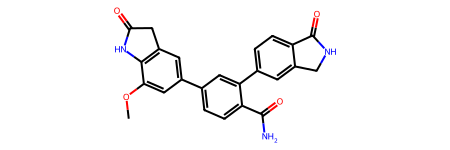

In [21]:
mols[0]

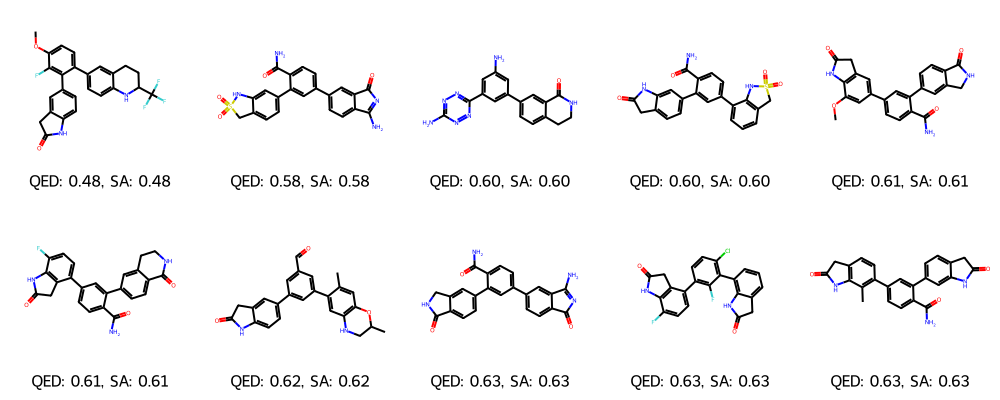

In [24]:
# get the 10 mols with highes sas
index = np.argsort(qeds)[:10]
top_sas_mols = [mols[i] for i in index]
top_sas_qeds = [qeds[i] for i in index]
top_sas_sas = [qeds[i] for i in index]

MolsToGridImage(top_sas_mols, molsPerRow=5, legends=[f'QED: {top_sas_qeds[i]:.2f}, SA: {top_sas_sas[i]:.2f}' for i in range(len(top_sas_mols))])

In [18]:
from rdkit import Chem

def filter_out_tricyclobutane(molecules):
    """
    Filter out molecules containing tricyclobutane substructures.
    
    Args:
        molecules: List of RDKit molecules or SMILES strings
        
    Returns:
        List of molecules that do NOT contain tricyclobutane
    """
    # SMARTS pattern for tricyclobutane (three fused cyclobutane rings)
    # This identifies the core structure of a tricyclobutane
    tricyclobutane_pattern = Chem.MolFromSmarts('[#6]1[#6][#6]2[#6]3[#6][#6][#6]3[#6]12')
    
    # Convert SMILES to molecules if necessary
    mol_list = []
    for mol in molecules:
        if isinstance(mol, str):
            mol = Chem.MolFromSmiles(mol)
        if mol is not None:  # Skip invalid molecules
            mol_list.append(mol)
    
    # Filter out molecules with the tricyclobutane pattern
    filtered_mols = []
    for mol in mol_list:
        if not mol.HasSubstructMatch(tricyclobutane_pattern):
            filtered_mols.append(mol)
            
    return filtered_mols

In [19]:
filtered_mols = filter_out_tricyclobutane(mols)

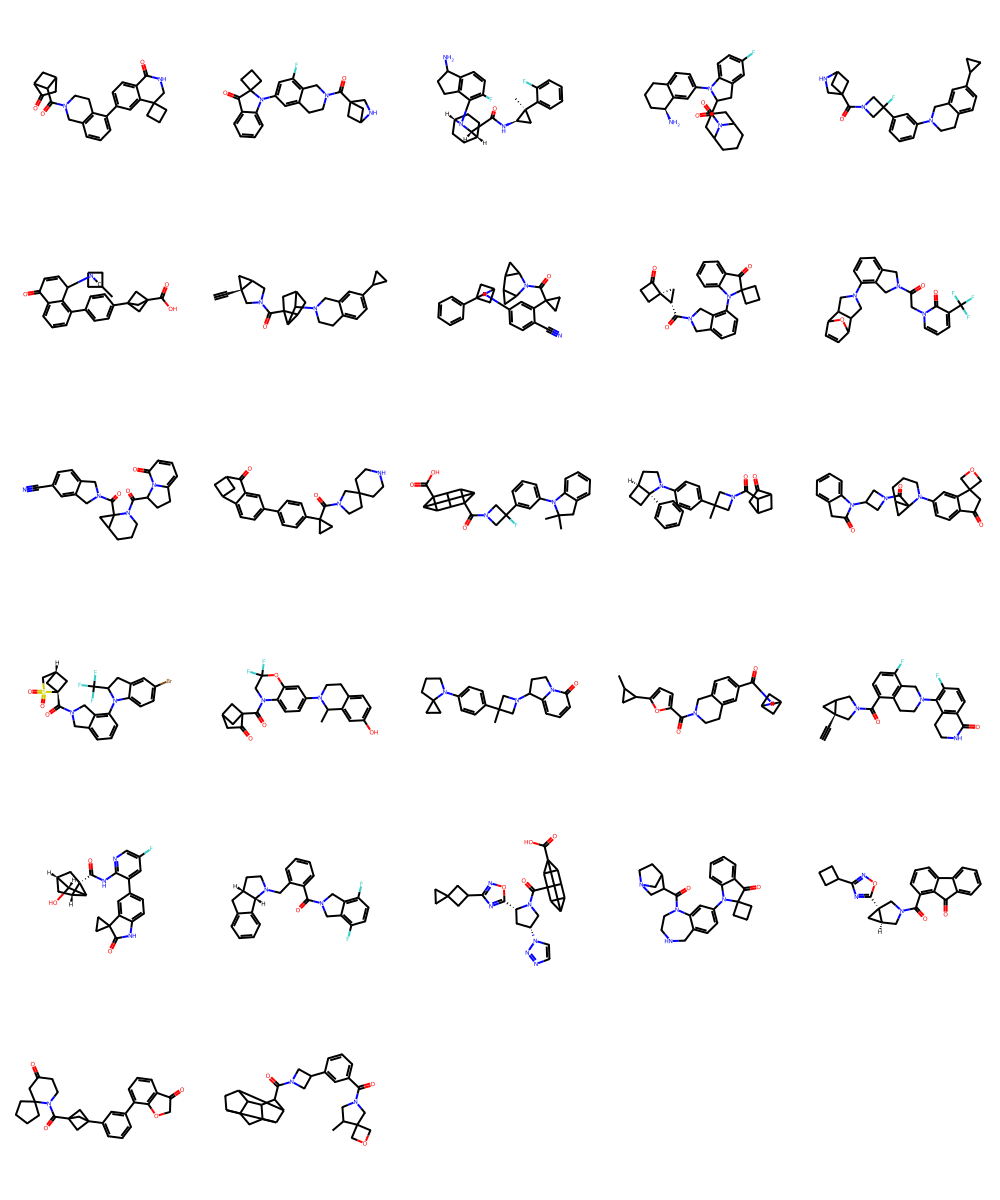

In [20]:

# use qed and sas as ledgen
MolsToGridImage(filtered_mols, molsPerRow=5)

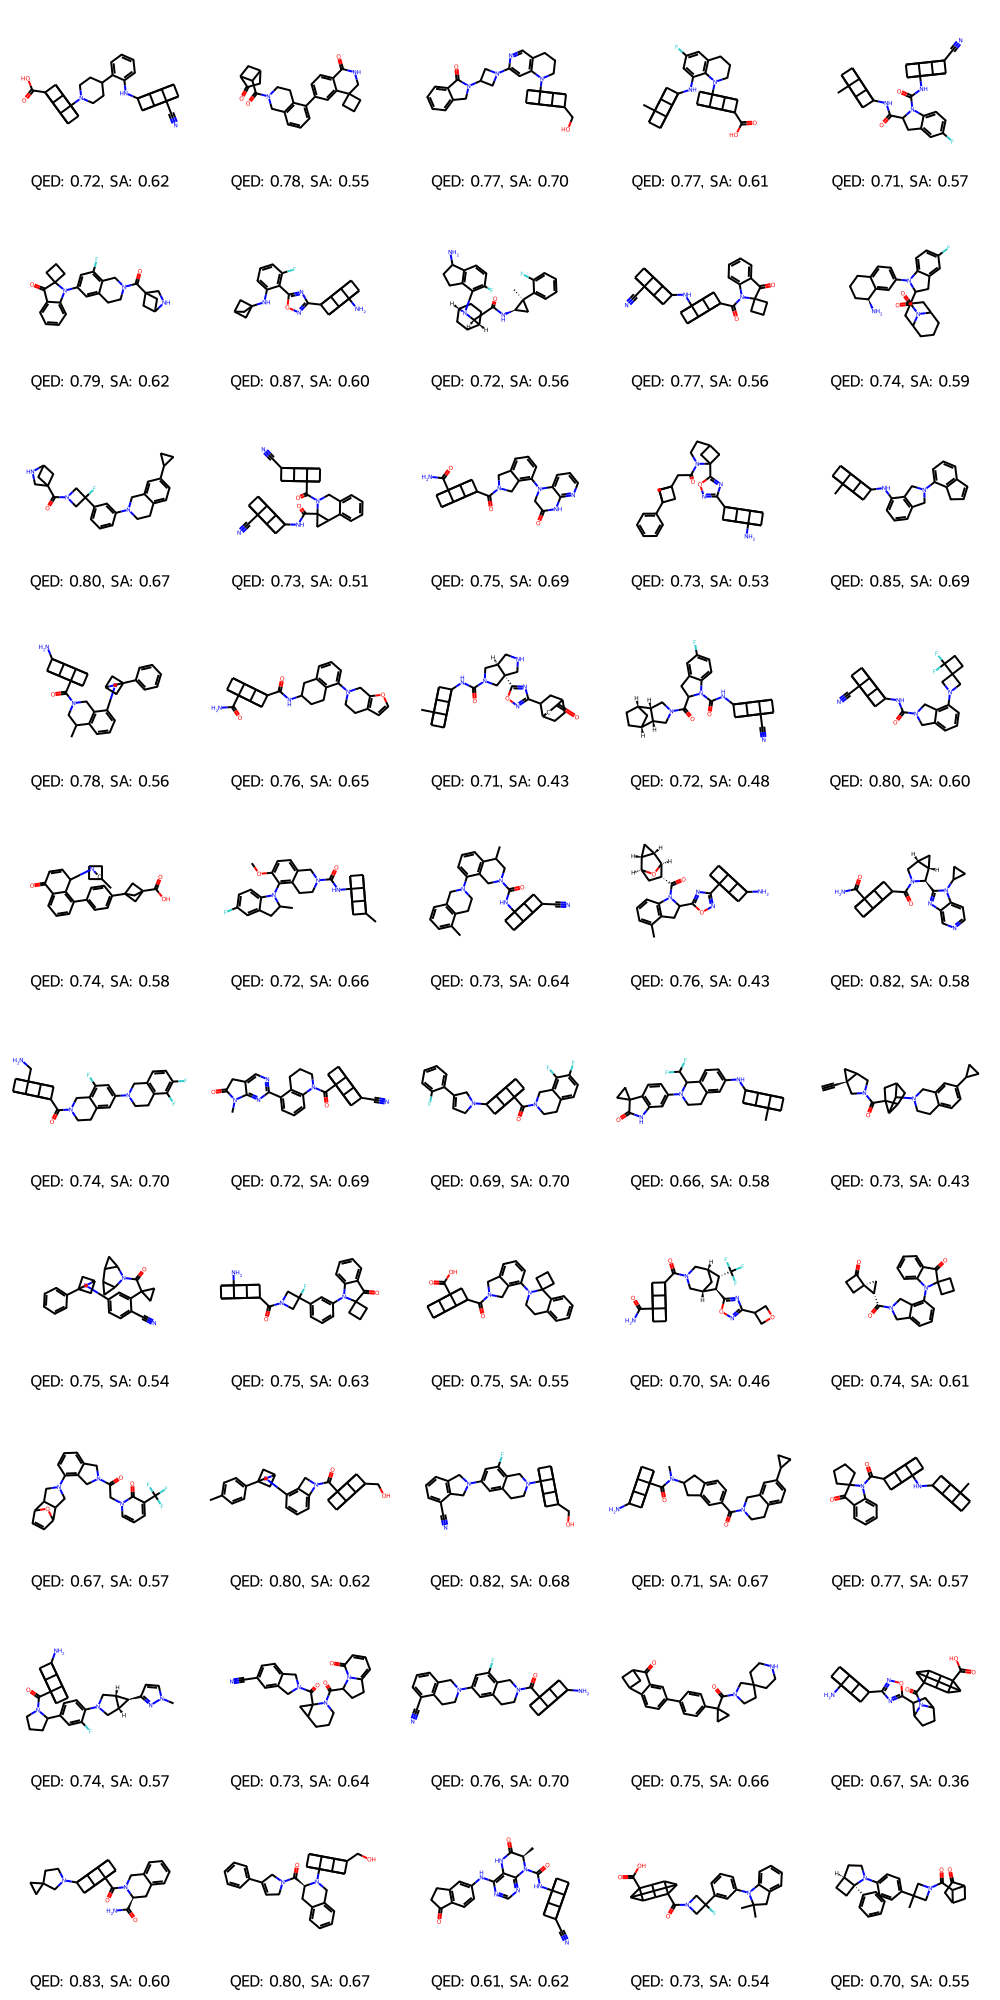

In [ ]:

# use qed and sas as ledgen
MolsToGridImage(mols, molsPerRow=5, legends=[f'QED: {qeds[i]:.2f}, SA: {sas[i]:.2f}' for i in range(len(mols))])

In [2]:

import pickle
results = pickle.load(open('model_output.pkl', 'rb'))

In [3]:
smiles = [m['smiles'] for m in results]

In [4]:
import sys
sys.path.append('/projects/jlab/to.shen/DeepDL')

In [10]:
%load_ext autoreload
%autoreload 2

from src.models.rnn import RNNLM

model_path = '/projects/jlab/to.shen/DeepDL/test/result/rnn_pubchem_worlddrug/'
model = RNNLM.load_model(model_path, 'cuda:0')

/projects/jlab/to.shen/DeepDL/src/models/default_model.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(load_save_file, map_location=devi

with open 

In [26]:
with open('../../../experiments/data/building_blocks/enamine_catalog.smi') as f:
    smiles_list = f.readlines()
smiles = [line.split("\t")[0] for line in smiles_list]

In [31]:
from tqdm import tqdm
from rdkit import Chem
from random import sample

subset = sample(smiles, 10000)

smiles_to_score = {}
for smile in tqdm(subset):
    if Chem.MolFromSmiles(smile) is not None and '.' not in smile:
        score = model.test(smile)
        smiles_to_score[smile] = score

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [01:04<00:00, 154.23it/s]


In [34]:
from collections import defaultdict

score_to_smiles = defaultdict(list)
for smile, score in smiles_to_score.items():
    score_to_smiles[score].append(smile)

sorted_scores = sorted(score_to_smiles.keys(), reverse=True)



In [85]:
sorted_scores[7040]

64.30888578907985

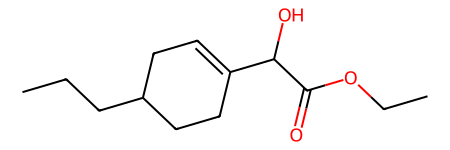

In [84]:
Chem.MolFromSmiles(score_to_smiles[sorted_scores[7040]][0])


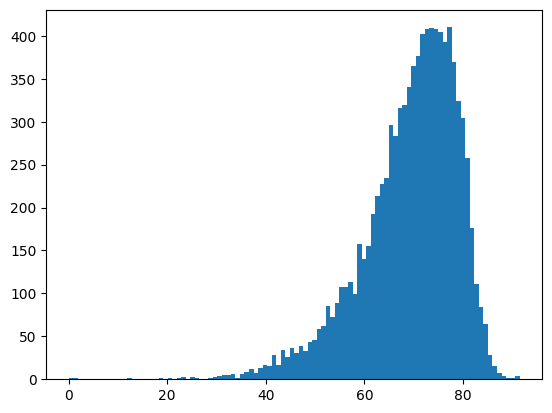

1.0%: 84.63584500539855
5.0%: 81.50324828292725
10.0%: 79.85987582719653
25.0%: 76.33507730233077
50.0%: 70.98700979469962
75.0%: 64.15412779458347
90.0%: 55.910396020775124
95.0%: 50.51735225350013
99.0%: 39.526348577865775


In [65]:
scores = list(smiles_to_score.values())

from matplotlib import pyplot as plt
plt.hist(scores, bins=100)
plt.show()



# plot various percentiles
percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
for p in percentiles:
    print(f"{p*100}%: {sorted_scores[int(len(sorted_scores)*p)]}")


